In [1]:
# Dataset: Syntetic dataset of water pipeline dataset.
# Method: Variational autoencoder is used to identify zero day attack. 

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

In [3]:
# Hyperparameters

NOISE = 0.4     # amount of noise to add to exercise 0.2
NETWORK = 'ANN'    # or ANN
THRESHOLD = 3      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.06 # threshold for deterministic 0.05 and for min and max : 0.03

In [4]:
def label_marker(row):
    if isinstance(row['result'], str) and 'Natural' in row['result']:
        return 0
    if isinstance(row['result'], str) and 'Attack' in row['result']:
        return 1
    return 

In [5]:
path ='F:/JD_Zero_Attack/Water Dataset/'

path_normal = path +'Water_syntheticdata_Normal_epoch100_100000.csv'
path_attack = path + 'Water_syntheticdata_Attack_epoch100_100000.csv'

normal_df = pd.read_csv(path_normal)  

attack_df = pd.read_csv(path_attack)  


#normal_df['result'] = normal_df.apply(label_marker, axis=1)
#attack_df['result'] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df["'result'"].to_numpy() 
attack_label = attack_df["'result'"].to_numpy() 

print('Normal Vectors with marker column',normal_df.shape)
print('Attack Vector with marker column',attack_df.shape)


Normal Vectors with marker column (100000, 24)
Attack Vector with marker column (100000, 24)


In [6]:
# Delete marker column 
normal_df.drop(["'result'"], axis=1, inplace=True)

attack_df.drop(["'result'"], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape without marker column',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape without marker column', attack_np.shape)


normal shape without marker column (100000, 23)
attack shape without marker column (100000, 23)


In [8]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

In [9]:
attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [10]:
normal_scaled.shape

(100000, 23)

In [11]:
attack_scaled.shape

(100000, 23)

In [12]:
# generate train set
# training set will consist of the normal ds

len_norm = len(normal_scaled)
len_norm_train = int(0.80 * len_norm)
X_train = normal_scaled[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = normal_scaled[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
#X_test = X_test_norm
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [13]:
X_train.shape

(80000, 23)

In [14]:
X_test_norm.shape

(20000, 23)

In [15]:
X_test_attack.shape

(20000, 23)

In [16]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
#intermediate_dim = 512
#latent_dim = 256

In [19]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [20]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [21]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [22]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [23]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=70,
                        batch_size=64)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples
Epoch 1/70
80000/80000 [==============================] - 4s 46us/sample - loss: 225.0333
Epoch 2/70
80000/80000 [==============================] - 3s 37us/sample - loss: 52.0561
Epoch 3/70
80000/80000 [==============================] - 3s 39us/sample - loss: 32.7079
Epoch 4/70
80000/80000 [==========

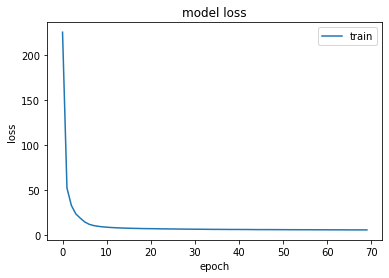

In [24]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [25]:
X_train_pred = vae_model.predict(X_train)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [26]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.98)
print(error_thresh)

Avg error 0.009437159203364208
median error 0.007605563317493938
99Q: 0.05200597689134632
setting threshold on 0.05200597689134632 
0.04336273838724763


In [27]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 40000
20418
total y_test 40000
20000


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     20000
         1.0       0.98      1.00      0.99     20000

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



In [29]:
X_pred.shape

(40000, 23)

In [30]:
X_encoded = encoder.predict(X_test)

C:\Users\darsh\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [31]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = encoder.predict(X_test)

In [32]:
# PCA transformation to observe variance in 2 components
pca = PCA(n_components=2, random_state=123)
X_transform = pca.fit_transform(X_pred2)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

C:\Users\darsh\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


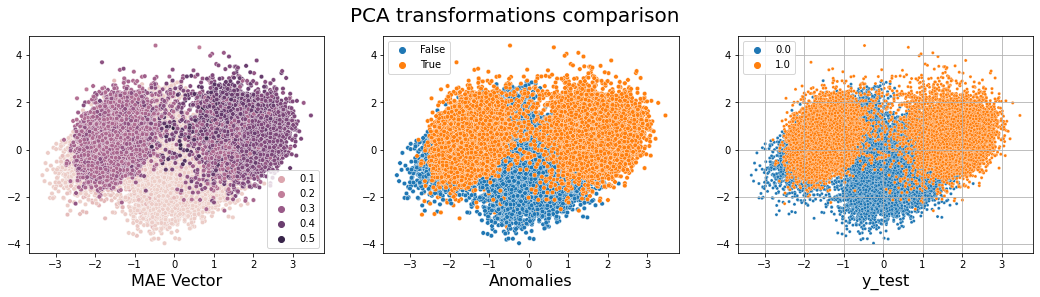

In [34]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.grid()
plt.show()

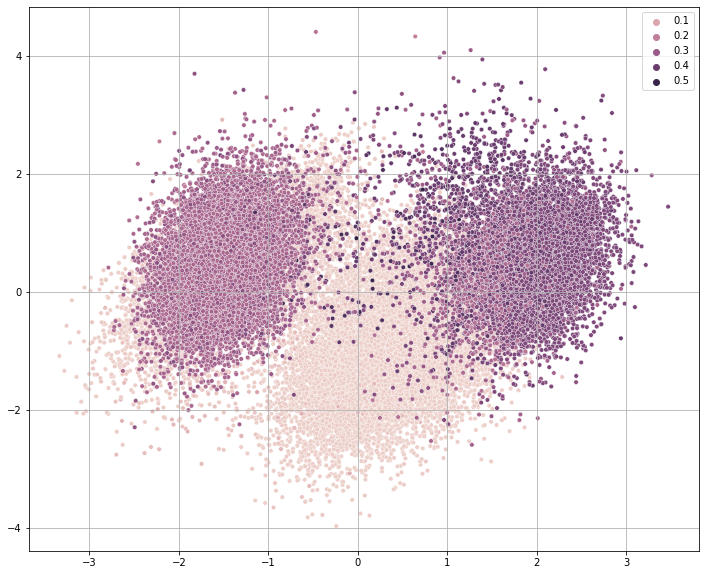

In [35]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

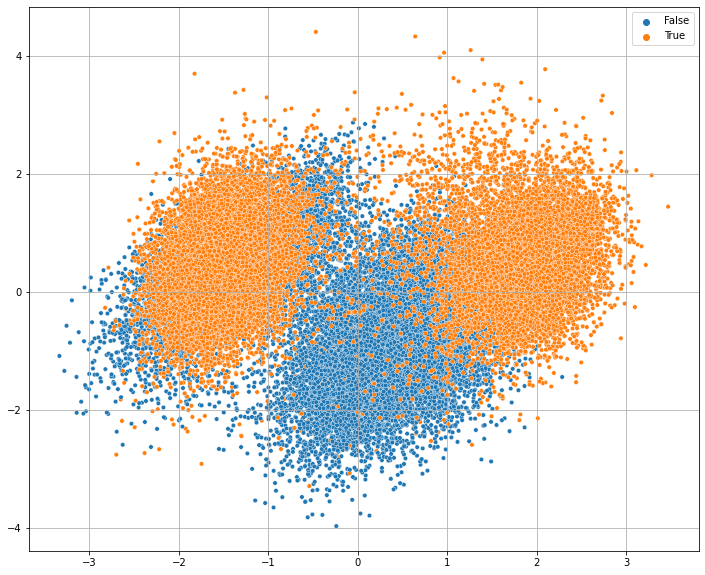

In [36]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

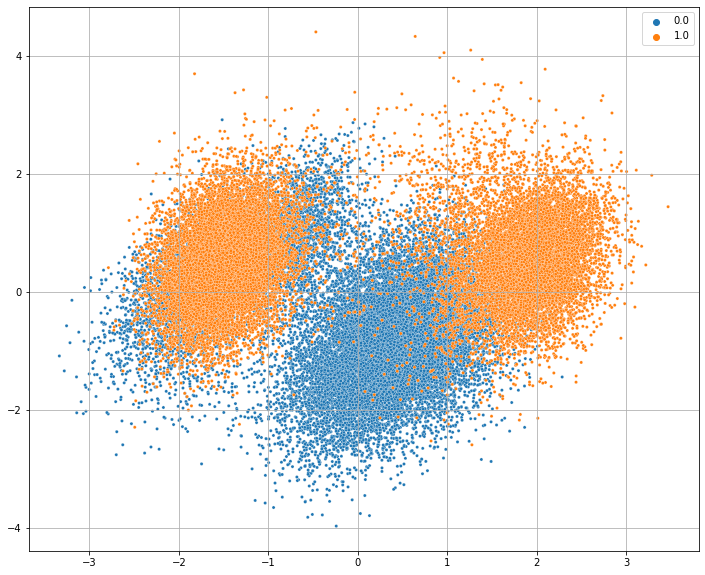

In [37]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [38]:
X_pred.shape

(40000, 23)

0.04336273838724763


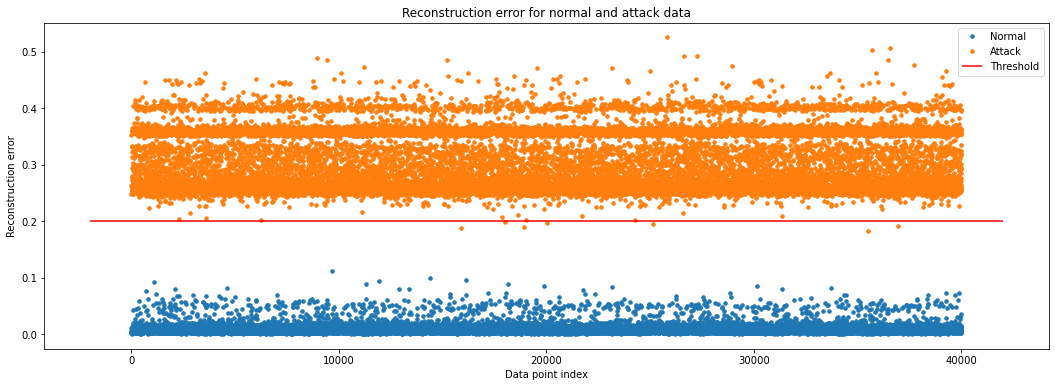

In [39]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = 0.2
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [40]:
lobal_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(Attack_error.shape, Normal_error.shape)

(20000,) (20000,)


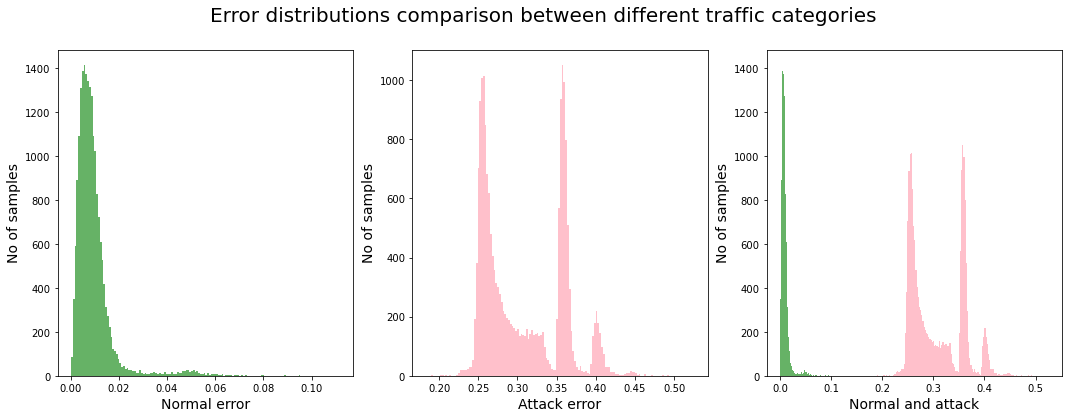

In [41]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distributions comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='pink')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='pink')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

In [42]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (20000,) 
 Normal_error shape (20000,)


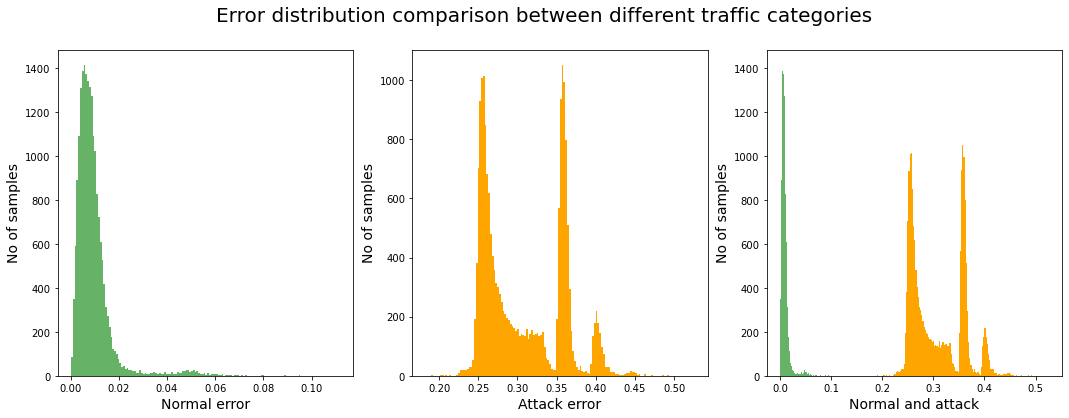

In [43]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()


In [44]:
print(Attack_error.shape, Normal_error.shape)

(20000,) (20000,)


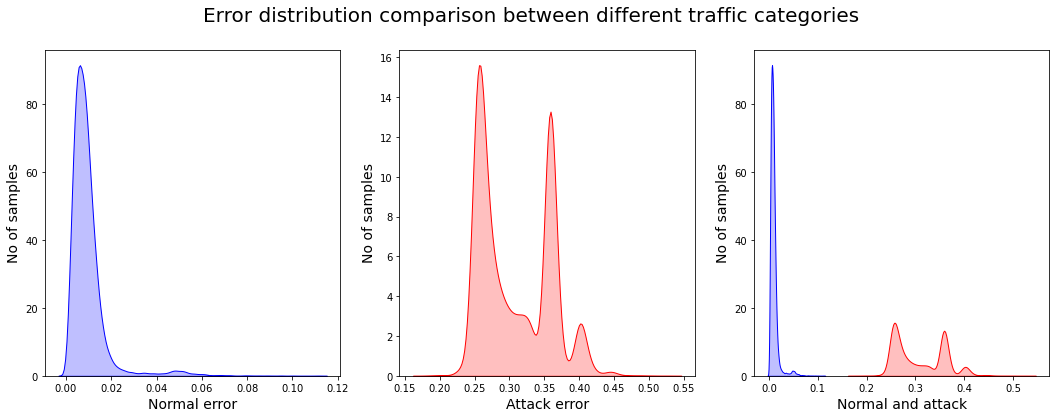

In [45]:
# Figure errors with KDE Plot

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
#ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)

sns.kdeplot(Normal_error,fill= True, ax = ax1,color   = 'blue')

ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
sns.kdeplot(Attack_error,fill= True, ax = ax2,color = 'red')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)

sns.kdeplot(Normal_error,fill= True, ax = ax3,color   = 'blue')
sns.kdeplot(Attack_error,fill= True, ax = ax3,color   = 'red')
#ax3.hist(Attack_error, bins=150, color='orange')
#ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

C:\Users\darsh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


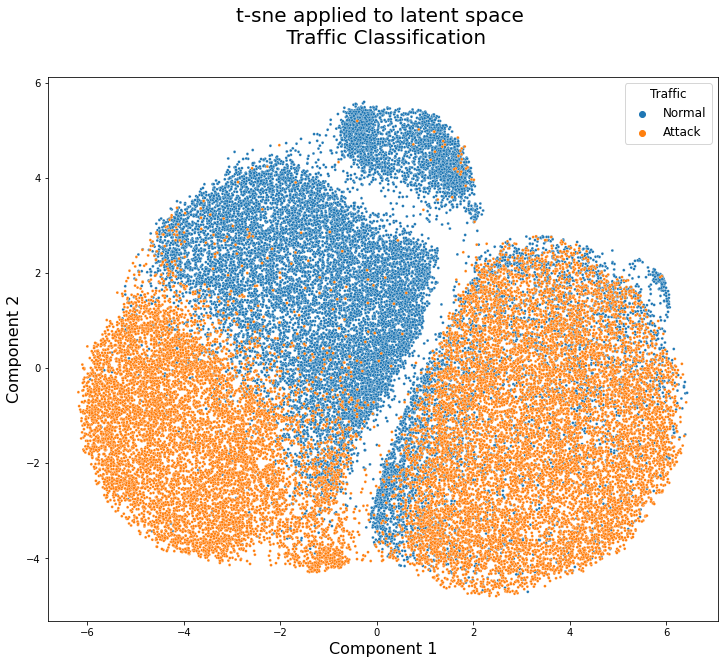

In [46]:
# Analisis latent space with t-SNE


tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=123)
tsne_results = tsne.fit_transform(X_pred2)

df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two']) 

plt.rcParams['axes.titley'] = 1.05
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('t-sne applied to latent space \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    alpha=1,
    data=df_subset,
    cmap=custom_cmap,
    s = 8
)
ax.set_xlabel('Component 1', size=16)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic', fontsize=12, title_fontsize=12)
plt.show()

In [47]:
# t-sne transformation to observe variance in 3 components of latent space

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300, init='pca', 
            random_state=123)
tsne_results = tsne.fit_transform(X_pred2)
df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two', 
                                              'tsne-2d-three']) 

C:\Users\darsh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


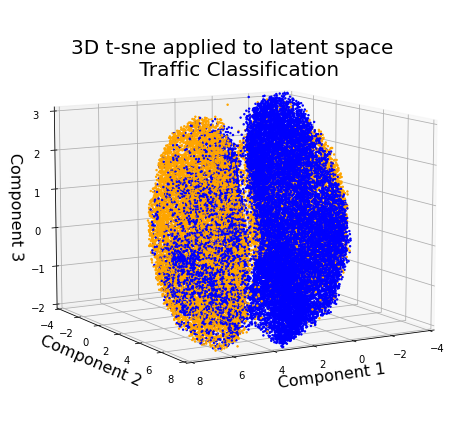

In [48]:
# t-sne figure
plt.rcParams['axes.titlepad'] = -14 
plt.rcParams['axes.titley'] = .95

fig = plt.figure(figsize=(6,6))
ax= Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.axes.set_xlim3d(left=-4, right=8)
ax.axes.set_ylim3d(bottom=-4, top=8)
ax.axes.set_zlim3d(bottom=-2, top=3)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sc = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
               c=y_test, alpha = 1, cmap=custom_cmap, s=2)
plt.title('3D t-sne applied to latent space \n Traffic Classification',size=20)

ax.set_xlabel('Component 1', size=16)
ax.set_ylabel('Component 2', size=16)
ax.set_zlabel('Component 3', size=16)
# rotate the axes and update
#fig.tight_layout()
fig.subplots_adjust(left=0, right=1, bottom=-10, top=-2)
ax.view_init(10, 60)
plt.show()


### 